# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

# Откройте и изучите файл

##   Откроем и изучим данные

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from tqdm import tqdm

In [2]:
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except FileNotFoundError:
    data  = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


###  Комментарии к данным

---в датафрейме действительно нет пропусков, все данные присутсвуют

---данные состоят из 3200 строк и 5 колонок - количество звонков, количество минут, количество сообщений, количество использованного траффика и каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

------при общении с одногруппниками было озвучено мнение, что необходимо убрать колонку calls или minute, т.к. по сути это одни и те же данные, просто в разной интерпритации. И таблица корреляции показывает очень сильную взаимосвязь, поэтому считаю корректным убрать колонку calls

In [4]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [5]:
data = data.drop(['calls'], axis=1)
data.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


In [6]:
data.is_ultra.mean()*100

30.647168637212197

---соотношение наличия тарифа "ультра" к тарифу "смарт" = около 1/3. 

---лишь 30% пользователей находятся на тарифе "ультра"

#   Разбейте данные на выборки

## Разделение данных

In [7]:
df = data.copy()

### Разделение на 5 частей

--- Разделю данные на 5 условных частей и 1/5 выведу в отедельный датафрейм для дальшнейшего теста. На 3/5 будет обучаться модель и оставшаяся 1/5 пойдет на корм валидации.

In [8]:
df_test = df.sample(frac = 0.2)
df = df.drop(df_test.index)
df.reset_index(drop= True , inplace= True)
df_test.reset_index(drop= True , inplace= True )
print(" ТЕСТОВЫЙ ДАТАФРЕЙМ:")
print(df_test)
  
print(" РАБОЧИЙ ДАТАФРЕЙМ:")
print(df)

 ТЕСТОВЫЙ ДАТАФРЕЙМ:
     minutes  messages   mb_used  is_ultra
0     462.32      90.0  31239.78         0
1     272.85      40.0  19628.84         0
2     517.82       0.0  20207.50         0
3     302.11       0.0  34506.26         1
4     288.43      21.0  21722.72         1
..       ...       ...       ...       ...
638   535.56      47.0  21684.88         0
639   377.30      72.0  12003.47         0
640   641.87      41.0  30633.32         1
641   316.49      46.0  21354.67         1
642    12.70       0.0    492.03         1

[643 rows x 4 columns]
 РАБОЧИЙ ДАТАФРЕЙМ:
      minutes  messages   mb_used  is_ultra
0      311.90      83.0  19915.42         0
1      516.75      56.0  22696.96         0
2      745.53      81.0   8437.39         1
3      418.74       1.0  14502.75         0
4      344.56      21.0  15823.37         0
...       ...       ...       ...       ...
2566    92.39       2.0   4299.25         0
2567  1016.98      71.0  17787.52         1
2568   190.36       0.0

### Разделение на валидационный и обучающий датасет

---здесь разделяем рабочий датафрейм на обучающий и валидационный и будем их применять на обучении модели

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df.is_ultra

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2  , random_state=12345)

 ##  Исследуйте модели

###  Модель Random Forest

In [10]:
%%time

best_result = 0
best_depth = 0
best_est = 0
for depth in tqdm(range(1, 10)):
    for est in range(1, 75):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth =depth) 
        model.fit(features_train,target_train) 
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid,predictions) 
        if result > best_result:
            best_result = result
            best_depth = depth
            best_est = est
            
print('Accuracy лучшей модели:', best_result, 'Лучшая глубина дерева:', best_depth, 'Лучшее число деревьев:', est)

100%|██████████| 9/9 [00:46<00:00,  5.14s/it]

Accuracy лучшей модели: 0.829126213592233 Лучшая глубина дерева: 9 Лучшее число деревьев: 74
CPU times: user 45.9 s, sys: 297 ms, total: 46.2 s
Wall time: 46.2 s


---модель является наиболее точной, но самой медленной из изученных в теории

### Модель Logistic Regression

In [12]:
%%time
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100000)
model.fit(features_train,target_train) 
predictions_valid = model.predict(features_valid) 
accuracy = accuracy_score(target_valid, predictions_valid) 
print("Accuracy модели линейной регрессии:", accuracy)

Accuracy модели линейной регрессии: 0.7495145631067961
CPU times: user 16.2 ms, sys: 4.01 ms, total: 20.2 ms
Wall time: 19.6 ms


--- модель наиболее быстрая и с не очень высоким качеством обучения

--- были применены разные гиперпараметры solver, лучшее accuracy получилось с lbfgs

### Модель Decision Tree

In [13]:
%%time
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid,predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print('Accuracy лучшей модели:', best_result, 'Лучшая глубина дерева:', best_depth)

Accuracy лучшей модели: 0.8077669902912621 Лучшая глубина дерева: 7
CPU times: user 129 ms, sys: 13 µs, total: 129 ms
Wall time: 144 ms


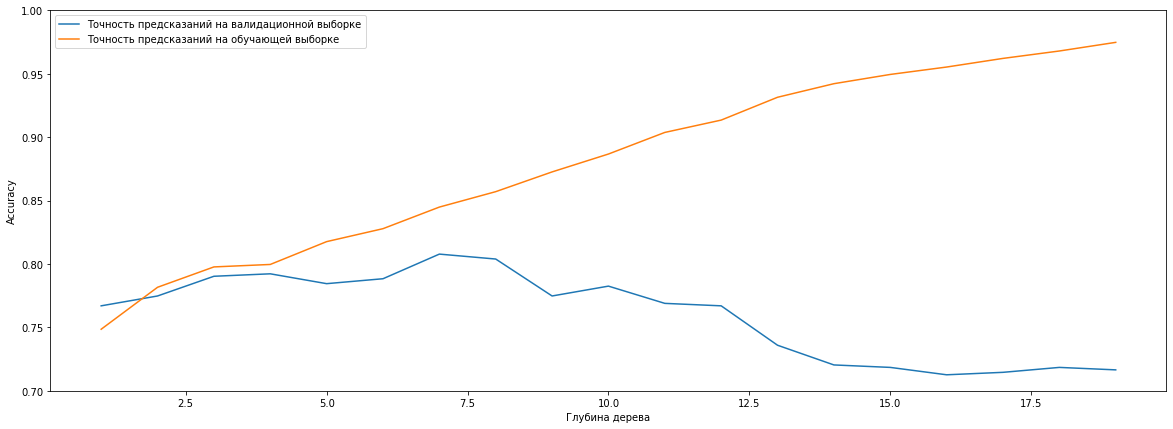

In [14]:
# код ревьюера

import matplotlib.pyplot as plt
import numpy as np

acc_valid = [] # сюда записывается accuracy по валидационной
acc_train = [] # сюда записывается accuracy по обучающей

depth_ = 20

for depth in range(1, depth_):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    
    predictions_valid = model_tree.predict(features_valid)
    predictions_train = model_tree.predict(features_train)
    
#     собираем результаты в списки
    acc_valid.append(accuracy_score(target_valid, predictions_valid))   
    acc_train.append(accuracy_score(target_train, predictions_train))   
    
    
fig, ax = plt.subplots(figsize = (20, 7))
fig.suptitle('')

# строи по спискам графики
ax.plot(np.arange(1, depth_), acc_valid, )
ax.plot(np.arange(1, depth_), acc_train)

ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy')

ax.legend(['Точность предсказаний на валидационной выборке', 'Точность предсказаний на обучающей выборке'])

plt.ylim(0.7, 1);  

---модель приемлемая по качеству и быстрая по времени

### Промежуточные итоги по работе моделей

---наиболее шустрая модель - Logistic Regression. Но не все должно измеряться скоростью. Модель допускает ошибки из за своего устройства

--- модель Decision Tree тоже быстрая и с хорошим качеством ответов. Возможно, что ее можно было бы выбрать, но если бы не точность следующей модели

---  Random Forest показывает лучший результат по ответам, но очень медленную работу. Это связано с многовариантностью модели и гибкими возможностями предсказаний. Наш массив небольшой и страшно представить, сколько будет обучаться модель на действительно больших данных

## Проверьте модель на тестовой выборке

### Проверка Random Forest на тестовой выборке

In [15]:

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test.is_ultra

model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth)
model.fit(features_train,target_train) 
predictions = model.predict(features_test)
result = accuracy_score(target_test,predictions)

print("Accuracy тестовой выборки:", result )

Accuracy тестовой выборки: 0.8118195956454122


---проверка показала приблизительно одинаковый показатель точности ответов c валидационным датасетом

---некторое различие присутсвует, но если бы оно было в большую  или меньшую сторону сильнее, то это бы означало недобученность или переобучение модели

## Проверка с помощью DummyClassifier


In [16]:
%%time
dummy_model = DummyClassifier(strategy='most_frequent', random_state= 12345)
dummy_model.fit(features_train,target_train)
print('Accuracy эталонного классификатора :', dummy_model.score(features_test,target_test))

Accuracy эталонного классификатора : 0.7045101088646968
CPU times: user 3.21 ms, sys: 50 µs, total: 3.26 ms
Wall time: 2.06 ms


--- DummyClassifier показывает точность , которая соответсвует распределению тарифов в данных

--- наши данные довольно незамысловатые и фиктивный классификатор показывает наиболее частую метку класса. у нас это тариф "смарт"

--- в двух случаях из трех наша модель будет предсказывать тариф "смарт" и это показывает уровень адекватности